# Kaggle Survey 2019 - Data Academy - Assessment 1

## Import packages

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from mord import LogisticAT

## Import the data

In [36]:
# Get the data skipping the 2nd row that contains column desciptions.
# This avoids Pandas returning an error regarding mixed data types.
df = pd.read_csv("multiple_choice_responses.csv", skiprows=[1])

# Check the dimensions.
dims = df.shape

# Get column names.
colnames = df.columns.tolist()

## Check missingness statistics

In [37]:
# Find % of missing values in each column and sort it. 
missing_stats = (df.isna().sum()/dims[0]).sort_values()

# Get names of columns where the percentage is 0%.
colnames_noblanks = missing_stats[missing_stats == 0].index.tolist()

# Get names of columns where the percentage is not 0%.
colnames_blanks = missing_stats[missing_stats != 0].index.tolist()

## Analyse the time spent on completing the survey

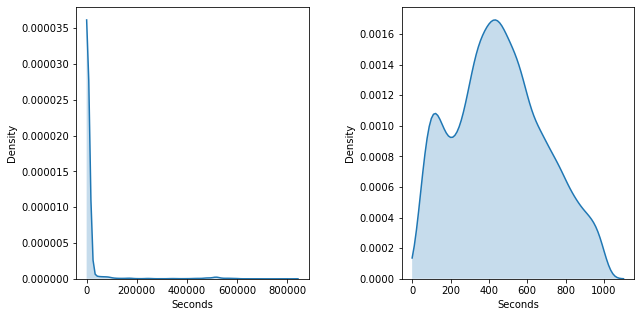

In [38]:
# Plot the distribution of duration.
max_duration = df["Time from Start to Finish (seconds)"].max()
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 5)

# Overall distribution.
ax[0] = sns.distplot(df["Time from Start to Finish (seconds)"], 
                     hist=False, 
                     rug=False, 
                     kde=True, 
                     kde_kws={"clip":(0, max_duration), "shade": True}, 
                     ax=ax[0]);
ax[0].set(xlabel="Seconds", ylabel="Density");

# The same distribution as above but for values between 0 and 1000.
ax[1] = sns.distplot(df["Time from Start to Finish (seconds)"][df["Time from Start to Finish (seconds)"] <1000], 
                     hist=False, 
                     rug=False, 
                     kde=True, 
                     kde_kws={"clip":(0, max_duration), "shade": True}, 
                     ax=ax[1]);
ax[1].set(xlabel="Seconds", ylabel="Density");

# Adjust the space between the graphs and export the figure.
fig.subplots_adjust(wspace=0.4)
fig.savefig("real_duration.png", bbox_inches='tight')

# Table of percentiles.
percentiles_table = df["Time from Start to Finish (seconds)"].quantile(np.linspace(.1, 1, 9, 0))

# Table of binned values.
bins = np.linspace(0, 1200, 20, 0).tolist()
bins.append(max_duration)
bins_counts = pd.cut(df["Time from Start to Finish (seconds)"], bins).value_counts().sort_index()

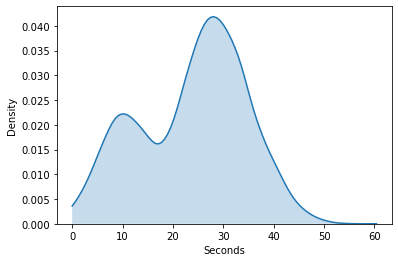

In [39]:
# Create an artificial distribution.

# Assumptions:
# Durations of responses of people in "group_1" follows a Normal (mean = 5*5, st.dev. = 5) distribution.
# Durations of responses of people in "group_2" follows a Normal (mean = 6*5, st.dev. = 5) distribution.
# Durations of responses of people in "group_3" follows a Normal (mean = 7*5, st.dev. = 5) distribution.
# Durations of responses of people in "group_4" follows a Normal (mean = 8*5, st.dev. = 5) distribution.
# Durations of responses of people in "group_5" follows a Normal (mean = 10, st.dev. = 5) distribution.
# Groups 1 to 4 comprise individuals who would answer the questions honestly and pay
# attention to ensure they provide accurate answers. 
# For those groups, each subsequent group would on average take 5 more seconds to fill the questionnaire.
# Group 5 consists of those who simply want to quickly submit their responses. 

# Simulate the data.
group_1 = np.random.normal(5*5, 5, 10000).tolist()
group_2 = np.random.normal(6*5, 5, 10000).tolist()
group_3 = np.random.normal(7*5, 5, 3000).tolist()
group_4 = np.random.normal(8*5, 5, 2000).tolist()
group_5 = np.random.normal(10, 5, 10000).tolist()
group_combined = group_1 + group_2 + group_3 + group_4 + group_5

# Plot the density.
max_combined = max(group_combined)
fig = sns.distplot(group_combined, hist=False, rug=False, 
                  kde=True, kde_kws={"clip":(0, max_combined), "shade": True});
plt.xlabel("Seconds");
plt.ylabel("Density");
fig = fig.get_figure() 
fig.savefig("fake_data.png", bbox_inches='tight')

## Kagglers - who are they? 

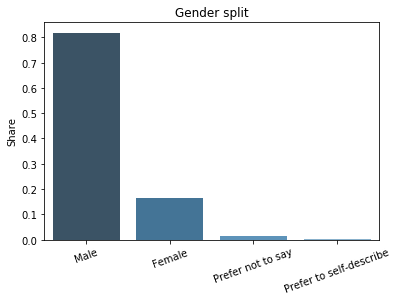

In [40]:
# Analysis of gender.
gender_barplot_data = df["Q2"].value_counts()/dims[0]
gender_barplot_data = pd.DataFrame({'Gender':gender_barplot_data.index,
                                    'Share':gender_barplot_data.values})

fig = sns.barplot(y = "Share", x = "Gender", data=gender_barplot_data, palette="Blues_d")
fig.set_xlabel('')
fig.set_title('Gender split')
plt.xticks(rotation=20);
fig = fig.get_figure() 
fig.savefig("gender.png", bbox_inches='tight')

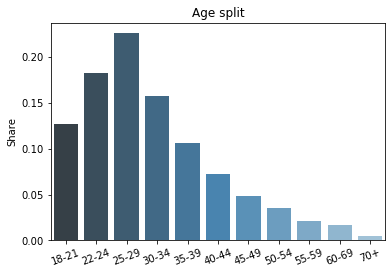

In [41]:
# Analysis of age.
age_barplot_data = df["Q1"].value_counts()/dims[0]
age_barplot_data = pd.DataFrame({'Age':age_barplot_data.index,
                                 'Share':age_barplot_data.values}).sort_values(['Age'])

fig = sns.barplot(y = "Share", x = "Age", data=age_barplot_data, palette="Blues_d")
fig.set_xlabel('')
fig.set_title('Age split')
plt.xticks(rotation=20);
fig = fig.get_figure() 
fig.savefig("age.png", bbox_inches='tight')

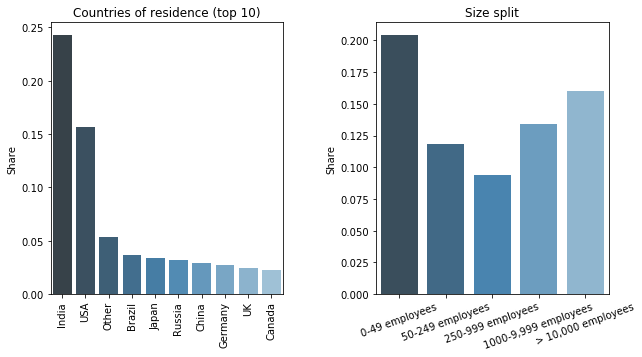

In [42]:
# Analysis of nationality - top 10.
# Prepare the data.
nat_barplot_data = df["Q3"].value_counts()/dims[0]
nat_barplot_data = pd.DataFrame({'Country':nat_barplot_data.index,
                                 'Share':nat_barplot_data.values}).head(10)

nat_barplot_data["Country"] = ["India", "USA", "Other", "Brazil", "Japan",
                              "Russia", "China", "Germany", "UK", "Canada"]

# Analysis of company size.
# Prepare the data.
size_barplot_data = df["Q6"].value_counts()/dims[0]
size_barplot_data = pd.DataFrame({'Size':size_barplot_data.index,
                                  'Share':size_barplot_data.values}).sort_values(['Size'])

order_company = ["0-49 employees", "50-249 employees", "250-999 employees",
                "1000-9,999 employees", "> 10,000 employees"] 

size_barplot_data["Size"] = pd.Categorical(size_barplot_data["Size"], 
                                           categories=order_company, ordered=True)

# Plot the two figures together.
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 5)

ax[0] = sns.barplot(y = "Share", x = "Country", data=nat_barplot_data, palette="Blues_d", ax=ax[0]) 
ax[0].set(xlabel="", ylabel="Share")
ax[0].set_title('Countries of residence (top 10)')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

ax[1] = sns.barplot(y = "Share", x = "Size", data=size_barplot_data, palette="Blues_d", ax=ax[1])
ax[1].set(xlabel="", ylabel="Share")
ax[1].set_title('Size split')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=20)

# Adjust the space between the graphs and export the figure.
fig.subplots_adjust(wspace=0.4)
fig.savefig("country_size.png", bbox_inches='tight')

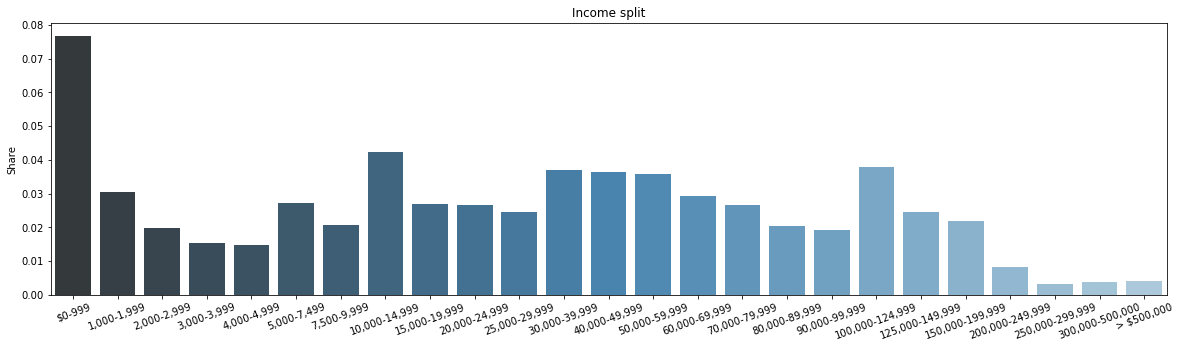

In [43]:
# Analysis of income.
income_barplot_data = df["Q10"].value_counts()/dims[0]
income_barplot_data = pd.DataFrame({'Income':income_barplot_data.index,
                                 'Share':income_barplot_data.values}).sort_values(['Income'])

order_income = ['$0-999', '1,000-1,999', '2,000-2,999', '3,000-3,999', '4,000-4,999', '5,000-7,499', '7,500-9,999',
        '10,000-14,999', '15,000-19,999', '20,000-24,999', '25,000-29,999','30,000-39,999',
        '40,000-49,999', '50,000-59,999', '60,000-69,999', '70,000-79,999', '80,000-89,999',
        '90,000-99,999', '100,000-124,999', '125,000-149,999', '150,000-199,999', '200,000-249,999',
        '250,000-299,999', '300,000-500,000', '> $500,000'] 

income_barplot_data["Income"] = pd.Categorical(income_barplot_data["Income"], categories=order_income, ordered=True)

income_barplot_data

plt.figure(figsize=(20,5))
fig = sns.barplot(y = "Share", x = "Income", data=income_barplot_data, palette="Blues_d")
fig.set_xlabel('')
fig.set_title('Income split')
plt.xticks(rotation=20);
fig = fig.get_figure() 
fig.savefig("income.png", bbox_inches='tight')

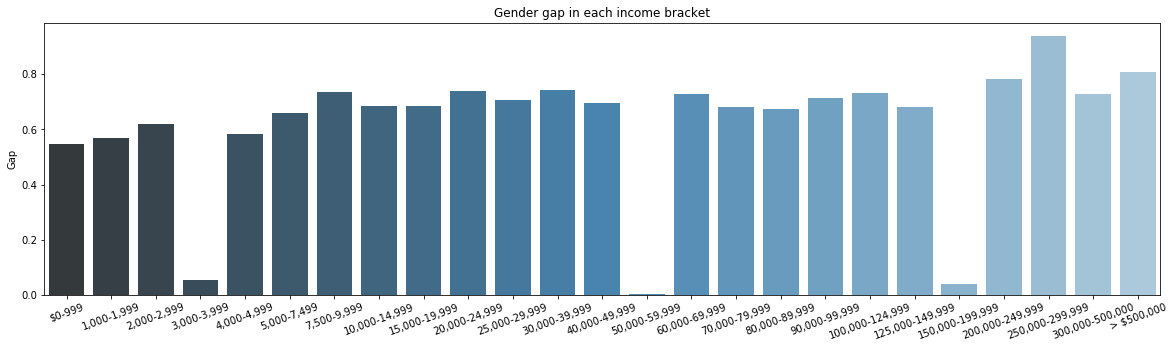

In [44]:
# Analysis of gender per income bracket - gaps between proportions.
# Considering a  male/non-male split.

# Find the proportions of males/non-males.
df["Male"] = ["Male" if x == "Male" else "Not_male" for x in df['Q2']]

income_gender_barplot_data = (df.groupby(["Q10", "Male"])["Time from Start to Finish (seconds)"]
                              .count().groupby(level=0).apply(lambda x: x / float(x.sum()))
                              .reset_index())

income_gender_barplot_data = (pd.DataFrame({'Income':income_gender_barplot_data["Q10"],
                                 'Gender':income_gender_barplot_data["Male"],
                                 'Share':income_gender_barplot_data["Time from Start to Finish (seconds)"]})
                              .sort_values(['Income']))

# Calculate the gaps.
income_gender_barplot_data["Gap"] = income_gender_barplot_data["Share"].diff(periods=-1).abs()

income_gender_barplot_data = income_gender_barplot_data[income_gender_barplot_data["Gender"] == "Male"]

income_gender_barplot_data ["Income"] = pd.Categorical(income_gender_barplot_data["Income"], 
                                                       categories=order_income, ordered=True)

# Drop the "Male" column from the main DataFrame.
df = df.drop(columns = ["Male"])

# Plot the gaps for each income category.
plt.figure(figsize=(20,5))
fig = sns.barplot(y = "Gap", x = "Income", data=income_gender_barplot_data.drop(columns = ["Share"]), palette="Blues_d")
fig.set_xlabel('')
fig.set_title('Gender gap in each income bracket')
plt.xticks(rotation=20);
fig = fig.get_figure() 
fig.savefig("income_gender.png", bbox_inches='tight')

## Ordinal logistic regression

####  Deal with "Text" columns.

In [45]:
# We are adjusting the contents of columns containing "Text" in their names.
# If the survey entry contained a text response - the column will contain 1.
# If the survey entry left the text field blank - the column will contain 0.
# At the moment, each positive integer in a column relates to one specific text response
# and grouping all of them together helps us create new features that are meaningful for the model below.
for col in colnames:
    if "TEXT" in str.split(col, "_"):
        df.loc[df[col] == -1, col] = 0
        df.loc[df[col] != -1, col] = 1

#### Missing values - multiple choice questions

In [46]:
# If we have a NaN in a field linked to a multiple choice question,
# we are assuming that not choosing a given response was intentional.
# In other words, not ticking a box in a survey should not correspond to a missing
# value as such. To fix that problem, we will replace all NaNs with 0s for
# those columns.

# Columns with "TEXT" and "Part" in their name do not have missing values,
# we do not need to worry about them.
for col in colnames:
    if "Part" in str.split(col, "_"):
        df.loc[df[col].isna(), col] = 0

#### Missing values - single choice questions

In [47]:
# Having done the operations above, drop all rows that still contain missing values.
# Those blank entries will be linked to single choice questions that were skipped in the process
# of filling the survey.
df = df.dropna()

new_dims = df.shape
print(new_dims)

### We now have 10541 rows.

(10541, 246)


#### Get dummy variables

In [48]:
# Get dummy variables based on categorical variables (one-hot encoding all categorical variables).
# Treat ordinal variables as numerical features.
num_cols = ['Time from Start to Finish (seconds)']
ord_cols = ['Q1', 'Q6', 'Q7', 'Q10', 'Q11', 'Q22', 'Q23']
not_dummy_colnames = num_cols + ord_cols
df = pd.get_dummies(df, columns = list(set(colnames) - set(not_dummy_colnames)))

#### Transform ordinal entries into numbers

In [49]:
# Some columns need to be manually processed as the "factorize" command does not correctly
# match categories to values (e.g. it believes that 50-249 employees > 1000-9999 employees).

def ordinal_to_num(col, order):
    '''
    INPUT:
    col - a column name 
    order - an ordered list of strings that are unique entries in the column
    
    OUTPUT:
    new_col - a new column where all strings are replaced with numerical entries
              and those values express the underlying order of the prior categorical
              entries
    '''
    new_col = pd.Categorical(df[col], categories=order, ordered=True)
    new_col = list(pd.factorize(df[col], sort=True)[0])
    
    return new_col

# "Q6" column.
col = "Q6"
uniq_vals = df[col].unique()
order = ["0-49 employees", "50-249 employees", "250-999 employees", "1000-9,999 employees", "> 10,000 employees"] 
df[col] = ordinal_to_num(col, order)

# "Q7" column.
col = "Q7"
uniq_vals = df[col].unique()
order = ['0', '1-2', '3-4', '5-9', '10-14', '15-19', '20+'] 
df[col] = ordinal_to_num(col, order)

# "Q10" column.
col = "Q10"
uniq_vals = df[col].unique()
order = ['$0-999', '1,000-1,999', '2,000-2,999', '3,000-3,999', '4,000-4,999', '5,000-7,499', '7,500-9,999',
        '10,000-14,999', '15,000-19,999', '20,000-24,999', '25,000-29,999','30,000-39,999',
        '40,000-49,999', '50,000-59,999', '60,000-69,999', '70,000-79,999', '80,000-89,999',
        '90,000-99,999', '100,000-124,999', '125,000-149,999', '150,000-199,999', '200,000-249,999',
        '250,000-299,999', '300,000-500,000', '> $500,000'] 
df[col] = ordinal_to_num(col, order)

# "Q11" column.
col = "Q11"
uniq_vals = df[col].unique()
order = ['$0 (USD)', '$1-$99', '$100-$999', '$1000-$9,999', '$10,000-$99,999', '> $100,000 ($USD)'] 
df[col] = ordinal_to_num(col, order)

# "Q22" column.
col = "Q22"
uniq_vals = df[col].unique()
order = ['Never', 'Once', '2-5 times', '6-24 times', '> 25 times'] 
df[col] = ordinal_to_num(col, order)

# "Q23" column.
col = "Q23"
uniq_vals = df[col].unique()
order = ['< 1 years', '1-2 years', '2-3 years', '3-4 years', '4-5 years', '5-10 years', '10-15 years', '20+ years'] 
df[col] = ordinal_to_num(col, order)

# "Q1" column.
col = "Q1"
uniq_vals = df[col].unique()
order = ['18-21', '22-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-69', '70+'] 
df[col] = ordinal_to_num(col, order)

In [50]:
# Check correlations with income.
corr_matrix_y = pd.DataFrame(df.corr(method="spearman")["Q10"])
corr_matrix_y["Absolute_value"] = corr_matrix_y["Q10"].abs()
corr_matrix_y.sort_values(["Absolute_value"], inplace=True, ascending=False)
corr_matrix_y.head(11)

,Q10,Absolute_value
Q10,1.000000,1.000000
Q1,0.132487,0.132487
Q15_< 1 years,-0.131713,0.131713
Q3_Germany,0.121391,0.121391
Q3_India,-0.112371,0.112371
Q6,0.110451,0.110451
Q3_Canada,0.091067,0.091067
Q25_Part_3_0,0.090084,0.090084
"Q25_Part_3_Automated model selection (e.g. auto-sklearn, xcessiv)",-0.090084,0.090084
Q3_Japan,0.085969,0.085969


#### Apply the model

In [51]:
# Split the data.
X = df.drop(columns = ["Q10"])
y = df["Q10"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=333)

# Create correlation matrix and drop highly correlated features from the model.
# This is to avoid multicolliniearity. 
corr_matrix = X.corr(method="spearman").abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

len(to_drop)
### In fact, 202 features out of 549 are highly correlated!
### We will drop them to avoid multicolliniearity. 

# Drop the columns.
X_train = X_train.drop(columns = to_drop)
y_train = y_train.drop(columns = to_drop)
X_test = X_test.drop(columns = to_drop)
y_test = y_test.drop(columns = to_drop)

# Fit the model.
model = LogisticAT(alpha=0)
model.fit(X_train, y_train)

LogisticAT(alpha=0, max_iter=1000, verbose=0)

In [52]:
# Assess the predictive power.

# Define the accuracy score that will be used to evaluate the model.
def acc_fun(target_true, target_fit):
    '''
    INPUT:
    target_true - a vector of actual labels 
    target_fit - a vector of predictions
    
    OUTPUT:
    score - estimated accuracy score
    '''
    target_fit = np.round(target_fit)
    target_fit.astype('int')
    score = accuracy_score(target_true, target_fit)
    
    return score

# Establish the score on the testing set using cross-validation.
acc = make_scorer(acc_fun)
acc_ordinal = cross_val_score(model,
    X_test,
    y_test,
    cv=3,
    scoring=acc)
print('Ordered logistic regression: ', np.mean(acc_ordinal))

Ordered logistic regression:  0.059743954480796585


In [53]:
# Establish the mean absolute error on the testing set as above.
MAE = make_scorer(mean_absolute_error)
mae_ordinal = cross_val_score(model,
    X_test,
    y_test,
    cv=3,
    scoring=MAE)

print('Ordered logistic regression: ', np.mean(mae_ordinal))

Ordered logistic regression:  7.079658605974395


In [54]:
# Analyse how many labels fall in each income category.
y_train.value_counts().sort_values(ascending = True)

24     42
11     45
14     48
9     118
15    190
12    192
20    253
7     256
23    264
22    279
6     320
10    321
8     346
1     354
17    363
4     365
5     374
21    380
19    428
18    483
13    511
16    521
3     526
2     566
0     887
Name: Q10, dtype: int64